In [1]:
import obonet
import networkx as nx

uberon=obonet.read_obo('./../annotation/uberon_ext.obo')
#dictionary of names to id 
id_to_name = {id_:data.get('name') for id_, data in uberon.nodes(data=True)}
name_to_id = {data.get('name'):id_ for id_, data in uberon.nodes(data=True)}

In [2]:
import sys
sys.path.append('./../src')

In [3]:
import pickle

with open('./../data/GEO/preprocessed/450K_Mvalues_atleast2_samplewise', 'rb') as f:
    mult_Mv, mult_meta, _ = pickle.load(f)

In [4]:
import copy
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import pandas as pd
import numpy as np 

In [11]:
class OntologyDAG:
    def __init__(self, graph, id_to_name, name_to_id):
        self.graph = graph
        self.name_to_id = name_to_id
        self.id_to_name = id_to_name
        self.root = None  # Initialize root as None
        
        self.graph.add_edge(self.name_to_id['lymphocyte'], 
                            self.name_to_id['peripheral blood mononuclear cell'], 
                            'is_a')
        
        self.reroute_blood()
        self.check_graph()
        self.filter_edge()
        self.check_graph()
        self.reroute('CARO:0000000', 'UBERON:0001062')
        self.reroute(self.name_to_id['exocrine pancreas'], self.name_to_id['pancreas'])
        self.reroute(self.name_to_id['endocrine pancreas'], self.name_to_id['pancreas'])
    
    def reroute_blood(self):
        # Remove edges only if they exist
        if self.graph.has_edge(self.name_to_id['monocyte'], self.name_to_id['mononuclear cell']):
            self.graph.remove_edge(self.name_to_id['monocyte'], self.name_to_id['mononuclear cell'])
        if self.graph.has_edge(self.name_to_id['lymphocyte'], self.name_to_id['mononuclear cell']):
            self.graph.remove_edge(self.name_to_id['lymphocyte'], self.name_to_id['mononuclear cell'])
        
        # Add edges only if they don't already exist
        if not self.graph.has_edge(self.name_to_id['leukocyte'], self.name_to_id['blood']):
            self.graph.add_edge(self.name_to_id['leukocyte'], self.name_to_id['blood'], 'is_a')
        if not self.graph.has_edge(self.name_to_id['monocyte'], self.name_to_id['peripheral blood mononuclear cell']):
            self.graph.add_edge(self.name_to_id['monocyte'], self.name_to_id['peripheral blood mononuclear cell'], 'is_a')
        if not self.graph.has_edge(self.name_to_id['lymphocyte'], self.name_to_id['peripheral blood mononuclear cell']):
            self.graph.add_edge(self.name_to_id['lymphocyte'], self.name_to_id['peripheral blood mononuclear cell'], 'is_a')
        
    def filter_edge(self, edge_types=['is_a', 'part_of']):
        '''
        Filter by edge type. Default: ['is_a', 'part_of']
        '''
        def edgefilter(n1, n2, edgekey):
            return edgekey in edge_types

        filtered_graph = nx.subgraph_view(self.graph, filter_edge=edgefilter)
        filtered_graph = nx.MultiDiGraph(filtered_graph)
        filtered_graph.remove_nodes_from(list(nx.isolates(filtered_graph)))
        
        self.graph = filtered_graph
        
    def reroute(self, from_node, to_node):
        tree_copy = copy.deepcopy(self.graph)
        for e in self.graph.in_edges(from_node):
            if e[0] != to_node:
                tree_copy.add_edge(e[0], to_node, list(self.graph.get_edge_data(e[0], e[1]).keys())[0])
            tree_copy.remove_edge(e[0], e[1])
        for e in self.graph.out_edges(from_node):
            if e[1] != to_node:
                tree_copy.add_edge(to_node, e[1], list(self.graph.get_edge_data(e[0], e[1]).keys())[0])
            tree_copy.remove_edge(e[0], e[1])
        print(f'{from_node} is isolate: {nx.is_isolate(tree_copy, from_node)}')
        tree_copy.remove_node(from_node)
        if from_node in self.id_to_name.keys(): self.id_to_name.pop(from_node)

        self.graph = tree_copy
        
    def create_subtree_root(self, tissues, root, display=False):
        self.root = root  # Set the root
        nodes = [self.name_to_id[x] for x in tissues if x in self.name_to_id.keys()]
        nodes.extend([x for x in tissues if x in self.id_to_name.keys()])
        root_node = self.name_to_id[root]
        root_children = nx.ancestors(self.graph, root_node)
        root_children.add(root_node)
        all_parents_under_root = [root_node]
        for num, node in enumerate(nodes):
            if node in self.graph.nodes:
                all_parents = nx.descendants(self.graph, node)
                parents_under_root = [x for x in all_parents if x in root_children]
                all_parents_under_root.append(node)
                [all_parents_under_root.append(x) for x in parents_under_root]
                if display:
                    print([self.id_to_name[x] for x in all_parents_under_root])
            else:
                print(f"{self.id_to_name[node]} not in tree")
                print()
                
        self.graph = nx.MultiDiGraph(self.graph.subgraph(all_parents_under_root))
        
    def collapse(self, tree, tissues):
        tree_copy = copy.deepcopy(tree)
        tree_copy = nx.MultiDiGraph(tree_copy)
        pos = graphviz_layout(tree, prog='dot', root=self.name_to_id[self.root])
        pos = {k: v for k, v in sorted(pos.items(), key=lambda item: item[1][1])}

        for node in pos.keys():
            if self.name_to_id['anatomical system'] in tree.successors(node) and self.id_to_name[node].split()[-1] == 'system':
                continue
            if self.id_to_name[node] not in tissues:
                parents = list(tree_copy.successors(node))
                children = list(tree_copy.predecessors(node))
                if len(parents) == 1 and len(children) == 1:
                    tree_copy.add_edge(children[0], parents[0], list(tree_copy.get_edge_data(node, parents[0]).keys())[0])
                    tree_copy.remove_node(node)
        return tree_copy

    def cut_collapse(self, wanted, unwanted):
        tree = copy.deepcopy(self.graph)
        cut_tree=tree.subgraph([x for x in tree.nodes() if x not in unwanted])
        cut_tree=nx.MultiDiGraph(self.collapse(cut_tree, [id_to_name[x] for x in wanted]))

        keep_comp=list()
        for comp in nx.weakly_connected_components(cut_tree):
            if len(comp.intersection(set(wanted)))==1: keep_comp.extend(list(comp.intersection(set(wanted))))
            elif any(n in wanted for n in list(comp)): keep_comp.extend(list(comp))
        cut_tree=nx.MultiDiGraph(cut_tree.subgraph([x for x in cut_tree.nodes() if x in keep_comp]))
            
        self.graph = cut_tree

    def remove_triangle(self, display=False):
        copy_tree = copy.deepcopy(self.graph)
        adj = pd.DataFrame(nx.to_numpy_array(copy_tree), index=copy_tree.nodes(), columns=copy_tree.nodes())
        adj2 = pd.DataFrame(np.matmul(adj, adj), index=copy_tree.nodes(), columns=copy_tree.nodes())

        for n in self.graph.nodes:
            children = adj[adj.loc[n] > 0].index
            grandchildren = adj2[adj2.loc[n] > 0].index
            triangle = children & grandchildren
            if len(triangle) > 0:
                for x in triangle:
                    copy_tree.remove_edge(n, x)
                    print(f"removed edge between {self.id_to_name[n]} and {self.id_to_name[x]}")
        self.graph = copy_tree

    def iteratively_cut_collapse(self, wanted, unwanted):
        cut_tree = copy.deepcopy(self.graph)
        keep_comp = list()
        for comp in nx.weakly_connected_components(cut_tree):
            if len(comp.intersection(set(wanted))) == 1:
                keep_comp.extend(list(comp.intersection(set(wanted))))
            elif any(n in wanted for n in list(comp)):
                keep_comp.extend(list(comp))
        cut_tree = nx.MultiDiGraph(cut_tree.subgraph([x for x in cut_tree.nodes() if x in keep_comp]))
        
        for node in cut_tree.nodes:
            node_parents=list(cut_tree.successors(node))
            node_children=list(cut_tree.predecessors(node))
            if node in wanted: continue
            elif (len(node_children)==0): unwanted.extend([node])
            elif (len(node_parents)==0 and len(node_children)==1): unwanted.extend([node])
            elif (node not in wanted) and (len(node_parents)==0 and len(node_children)==0): unwanted.extend([node])
            
        self.graph = cut_tree
            
        while (len(unwanted)>0):
            print(f'cut collapse: {len(unwanted)} nodes')
            self.cut_collapse(wanted, unwanted)
            self.remove_triangle()
            self.collapse_same_children_same_parents()
            
            unwanted=list()
            for node in self.graph.nodes:
                node_parents=list(self.graph.successors(node))
                node_children=list(self.graph.predecessors(node))
                if node in wanted: continue
                elif (len(node_children)==0): unwanted.extend([node])
                elif (len(node_parents)==0 and len(node_children)==1): unwanted.extend([node])
                elif (node not in wanted) and (len(node_parents)==0 and len(node_children)==0): unwanted.extend([node])
                
            print([self.id_to_name[x] for x in unwanted])
            print([self.id_to_name[x] for x in wanted])

                
        self.graph = cut_tree
        self.check_graph()
        self.display_graph()
        
    def collapse_same_children_same_parents(self):
        tree = copy.deepcopy(self.graph)
        nodelist=list(tree.nodes)
        samedict=dict()
        for i,node in enumerate(nodelist):
            wanted_children=set(list(nx.ancestors(tree,node)))
            wanted_parents=set(list(tree.successors(node)))
            samelist=list()
            if len(wanted_children)==0:
                continue
            for j in range(i+1, len(nodelist)):
                test_children=set(list(nx.ancestors(tree,nodelist[j])))
                test_parents=set(list(tree.successors(nodelist[j])))
                if wanted_children==test_children and wanted_parents==test_parents: 
                    if nodelist[j] not in samelist: samelist+=[nodelist[j]]
            if len(samelist)>0: samedict[node]=samelist
        [tree.remove_nodes_from(v) for k,v in samedict.items()]
        
        self.graph = tree

    def check_graph(self):
        if isinstance(self.graph, nx.MultiDiGraph):
            print(f"directed acyclic graph: {nx.is_directed_acyclic_graph(self.graph)}")
            print(f"weakly connected: {nx.is_weakly_connected(self.graph)}")
            print(f"strongly connected: {nx.is_strongly_connected(self.graph)}")
            print(f"weakly connected components: {[len(c) for c in nx.weakly_connected_components(self.graph)]}")
            print()
        else:
            print(f"connected: {nx.is_connected(self.graph)}")
            print(f"components: {[len(c) for c in nx.connected_components(self.graph)]}")
            print()
            
    def display_graph(self):
        import networkx as nx
        import matplotlib.pyplot as plt
        from networkx.drawing.nx_agraph import graphviz_layout

        # Create a copy of the graph for display
        display_graph = self.graph.copy()

        # Use id_to_name for node labels
        labels = {node: self.id_to_name[node] for node in display_graph.nodes()}

        # Position the nodes using graphviz_layout with 'dot' algorithm
        pos = graphviz_layout(display_graph, prog='dot')
        pos = {node: (x, -y) for node, (x, y) in pos.items()}

        # Draw the graph
        plt.figure(figsize=(20, 15))
        nx.draw(display_graph, pos, labels=labels, with_labels=True, node_size=1000, node_color='lightblue', 
                font_size=8, font_weight='bold', arrows=True)

        plt.title("Ontology DAG")
        plt.axis('off')
        # plt.tight_layout()
        plt.show()

# Create an instance of OntologyDAG
ontology_dag = OntologyDAG(uberon, id_to_name, name_to_id)
ontology_dag.check_graph()


directed acyclic graph: False
weakly connected: False
strongly connected: False
weakly connected components: [19557, 1, 6, 1]

directed acyclic graph: True
weakly connected: False
strongly connected: False
weakly connected components: [19425, 11, 6, 21]

CARO:0000000 is isolate: True
UBERON:0000017 is isolate: True
UBERON:0000016 is isolate: True
directed acyclic graph: True
weakly connected: False
strongly connected: False
weakly connected components: [19422, 11, 6, 21]



directed acyclic graph: True
weakly connected: False
strongly connected: False
weakly connected components: [139, 1]



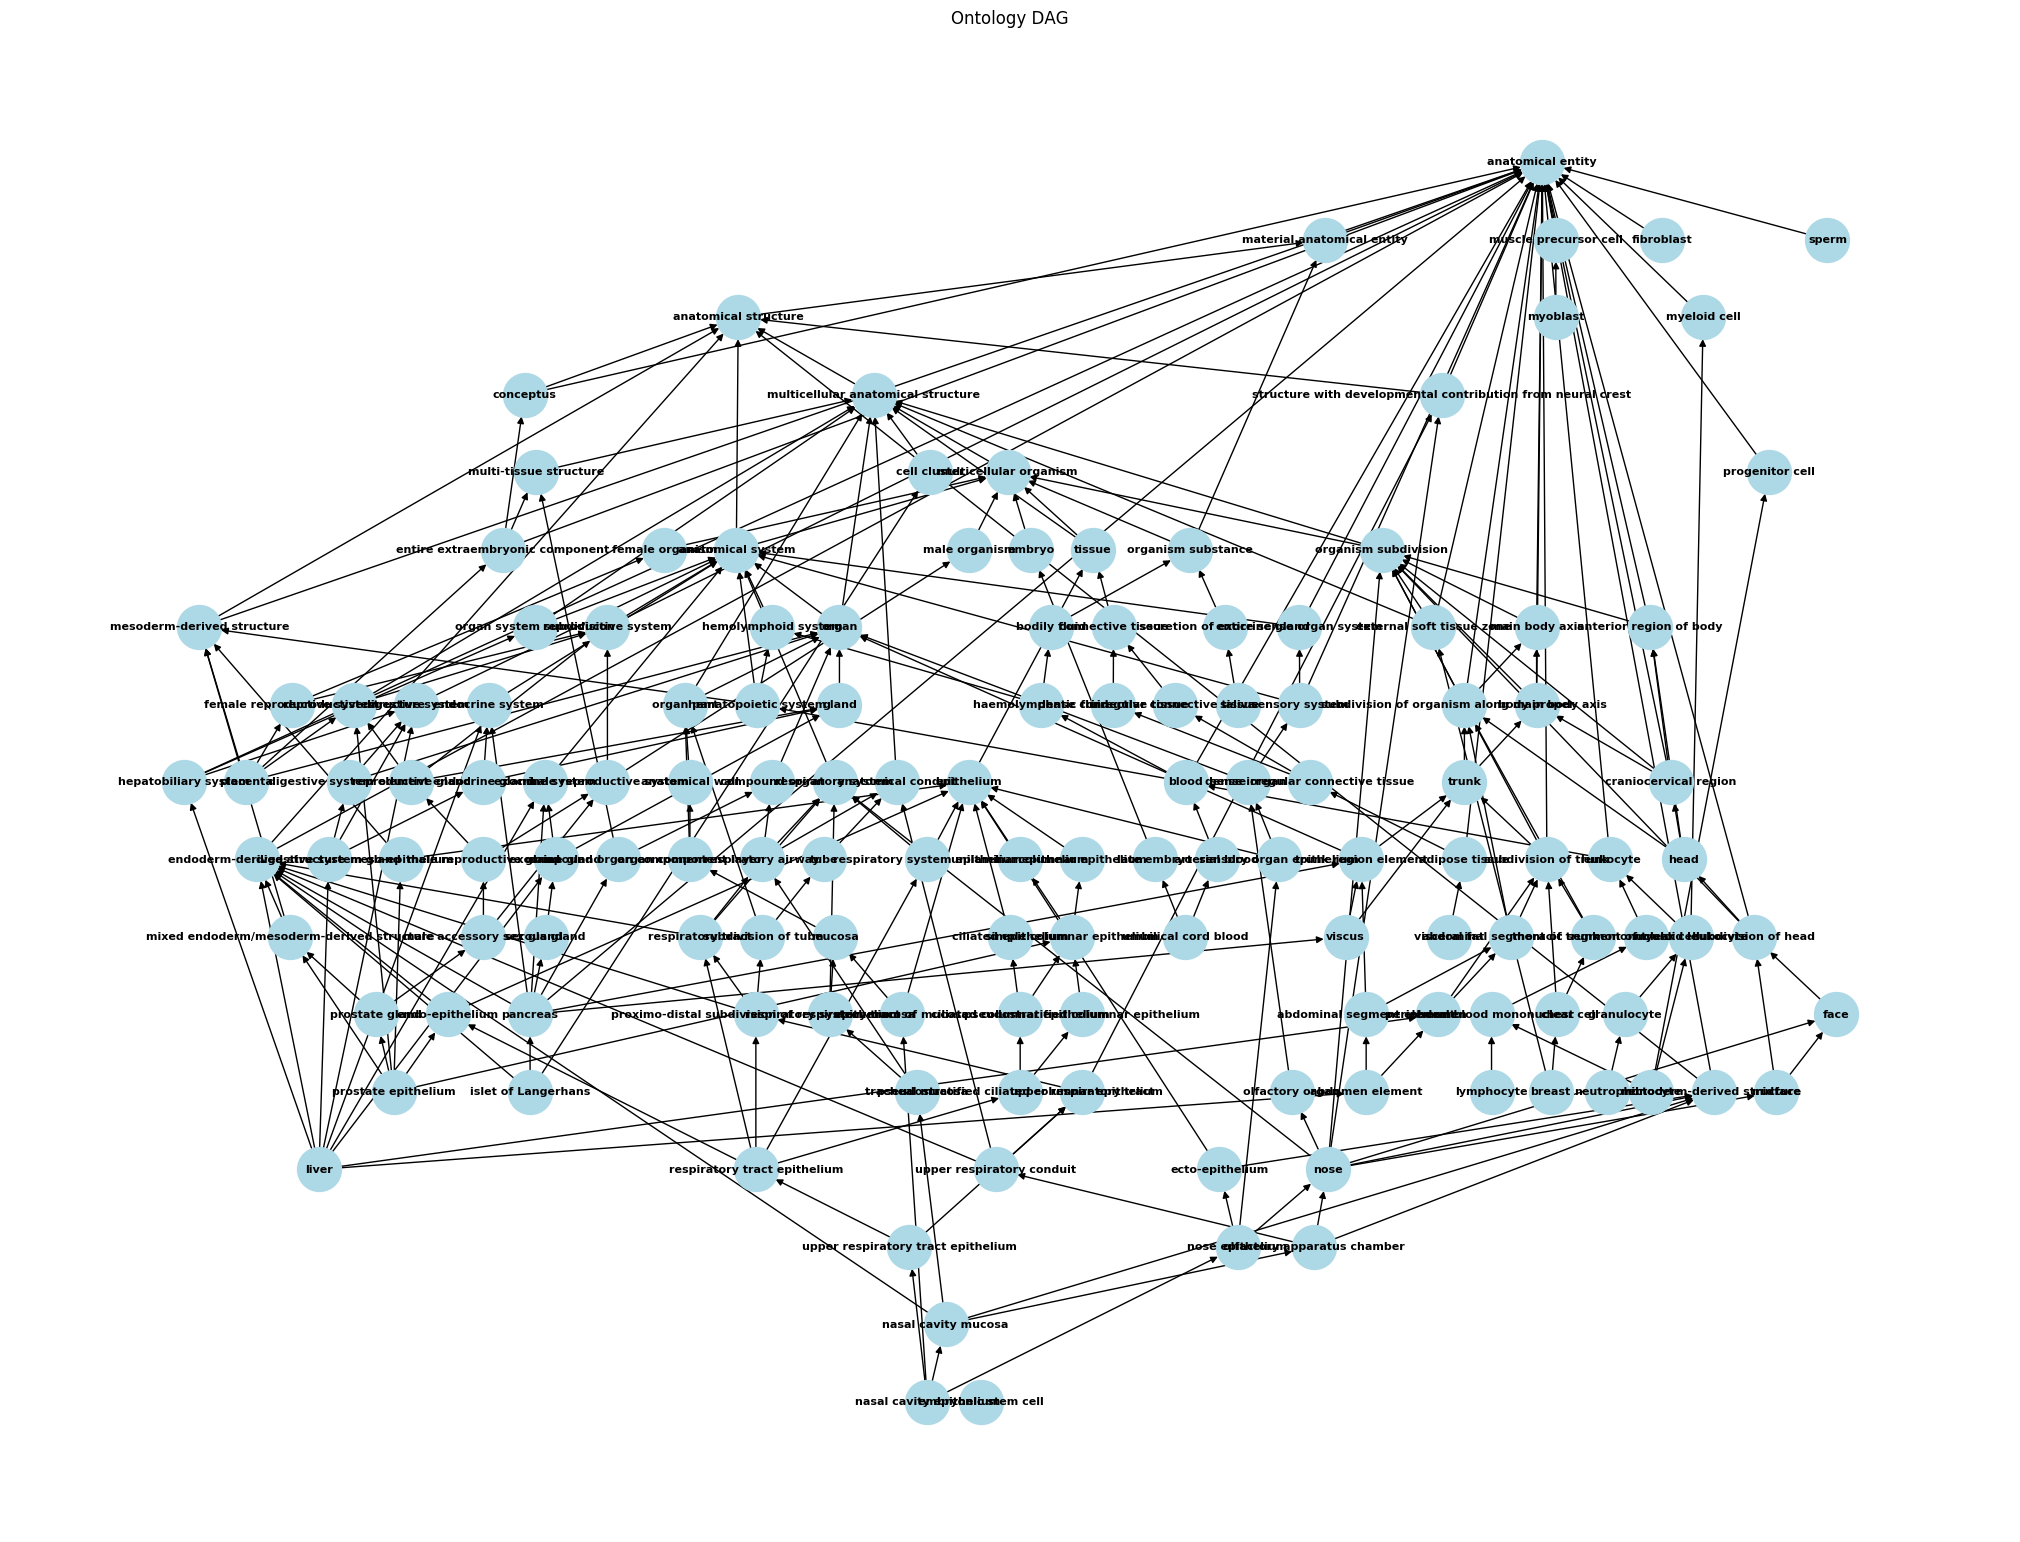

In [12]:
root = 'anatomical entity'
wanted_tissue = list(mult_meta['tissue_name'].unique())
ontology_dag.create_subtree_root(wanted_tissue, root)
ontology_dag.check_graph()
ontology_dag.display_graph()

In [13]:
def node_with_attribute(g, k, v=None):
    if v:
        return [n for n, d in g.nodes(data=True) if k in d and v in d[k]]
    else:
        return [n for n, d in g.nodes(data=True) if k in d]

field = "property_value"
value = "curator_notes \"Grouping term for query purposes\" xsd:string"
query_node = node_with_attribute(ontology_dag.graph, field, value)
[id_to_name[x] for x in query_node]

['mesoderm-derived structure',
 'endoderm-derived structure',
 'ectoderm-derived structure',
 'structure with developmental contribution from neural crest']

In [19]:
manual_exclude=['independent continuant','material entity','entity','anatomical collection', 'gland', 'anatomical conduit',
               'developing anatomical structure','midface','upper respiratory conduit','olfactory apparatus chamber',
               'structure with developmental contribution from neural crest','digestive system element','external soft tissue zone','extraembryonic structure',
               'object','root','conceptus','anterior region of body','tube','entire sense organ system','entire extraembryonic component', 
               "mucosa","sense organ","nose","face", 'appendage']

{'anatomical collection',
 'anatomical conduit',
 'anterior region of body',
 'appendage',
 'conceptus',
 'developing anatomical structure',
 'entire extraembryonic component',
 'entire sense organ system',
 'entity',
 'external soft tissue zone',
 'extraembryonic structure',
 'face',
 'gland',
 'independent continuant',
 'material entity',
 'midface',
 'mucosa',
 'nose',
 'object',
 'olfactory apparatus chamber',
 'root',
 'sense organ',
 'tube',
 'upper respiratory conduit'}

In [20]:

wanted_node=[name_to_id[x] for x in wanted_tissue]
unwanted_node = set()
unwanted_node = [node for node, data in ontology_dag.graph.nodes(data=True)
                 if 'subset' in data and
                 any(label in data['subset'] for label in 
                     ['non_informative', 'upper_level', 'grouping_class'])]
unwanted_node = list(unwanted_node) + list(query_node) + [name_to_id[x] for x in manual_exclude]


cut collapse: 65 nodes
removed edge between blood and hemolymphoid system
removed edge between pancreas and exocrine system
removed edge between prostate epithelium and epithelium
removed edge between male reproductive gland and reproductive system
removed edge between pseudostratified ciliated columnar epithelium and simple columnar epithelium
removed edge between male accessory sex gland and male reproductive system
removed edge between respiratory tract epithelium and respiratory system
removed edge between liver and digestive system
removed edge between liver and endocrine system
removed edge between liver and exocrine system
removed edge between ciliated columnar epithelium and epithelium
['progenitor cell', 'bodily fluid', 'myeloid cell', 'abdominal segment of trunk', 'female organism', 'digestive system', 'embryo', 'cell cluster', 'male organism', 'exocrine system', 'upper respiratory tract']
['placenta', 'peripheral blood mononuclear cell', 'monocyte', 'blood', 'breast', 'umbil

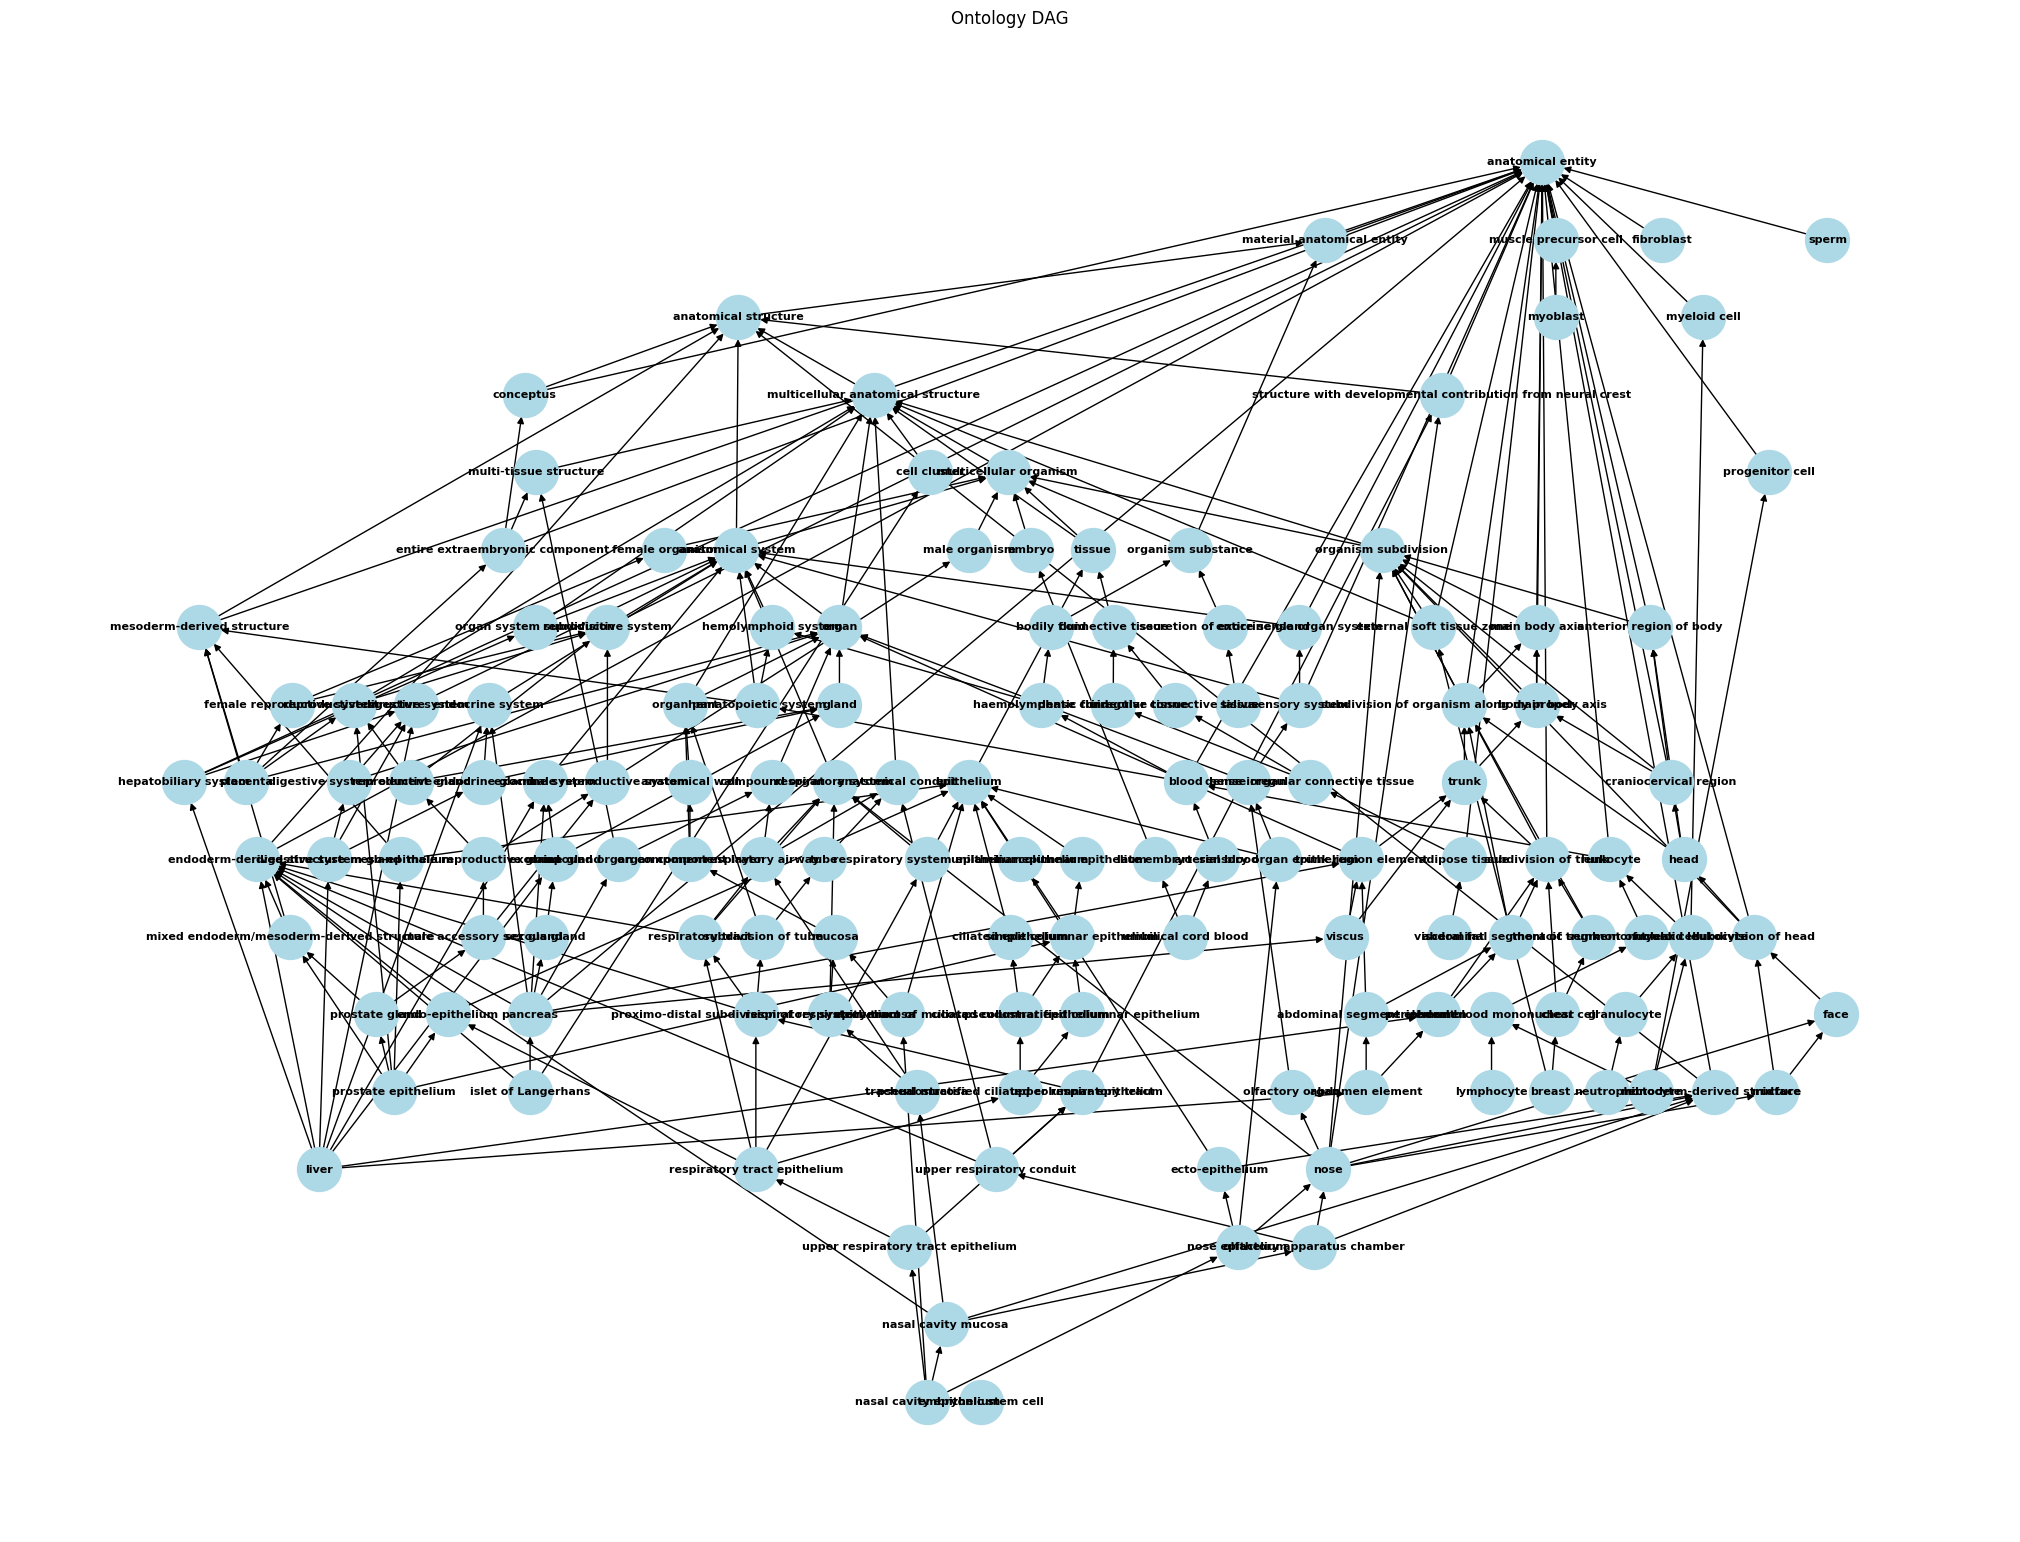

In [21]:
ontology_dag.iteratively_cut_collapse(wanted_node, unwanted_node)

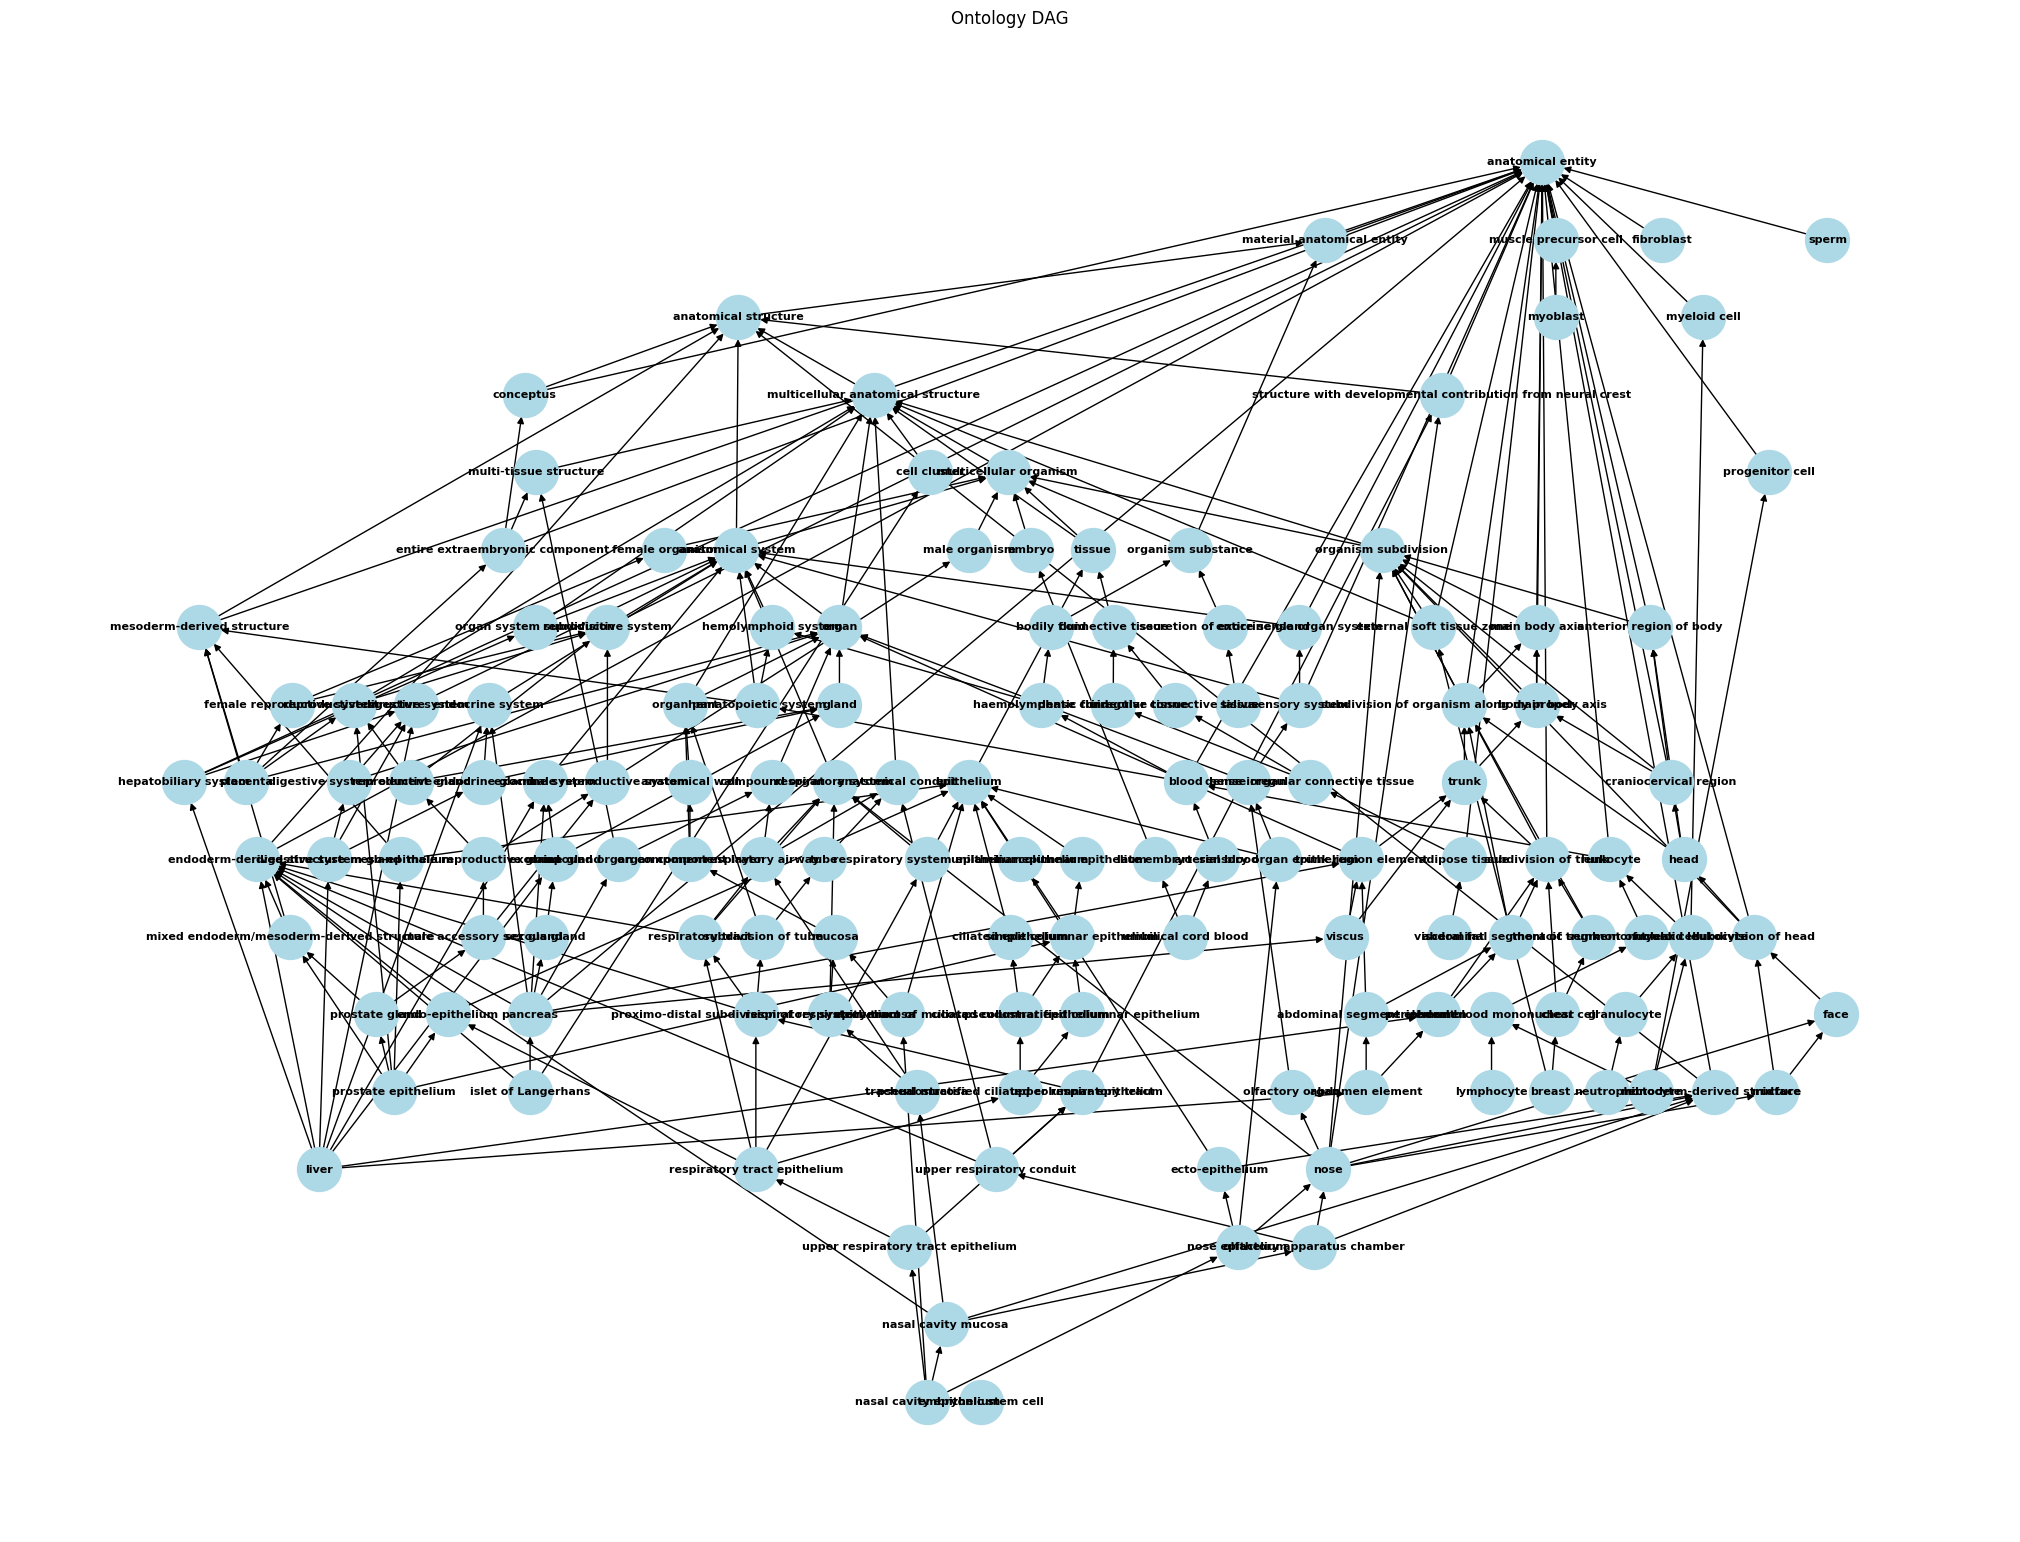

In [22]:
ontology_dag.display_graph()